# Introduction to Vision Transformers (ViT)

TOC:
- Attention, Self Attention and Multi-head Self Attention mechanisms
- Transformers
- Vision Transformers (ViT) paper by Google Research
- (Optional) Deit paper by FAIR


References:

- Official implementation with Jax/Flax by Google: https://github.com/google-research/vision_transformer
- Paper:  https://arxiv.org/abs/2010.11929
- One of PyTorch implementations:  https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py


![img](https://tse2.mm.bing.net/th?id=OIP.cyCA4XEM1F4ueNS2ADCa9wAAAA&pid=Api) | ![im](https://raw.githubusercontent.com/google-research/vision_transformer/master/figure1.png)
---|---


### Attention, Self Attention and Multi-head Self Attention mechanisms

#### Attention mechanism

Refs:
- https://d2l.ai/chapter_attention-mechanisms/index.html
- https://d2l.ai/chapter_attention-mechanisms/multihead-attention.html
- https://d2l.ai/chapter_attention-mechanisms/self-attention-and-positional-encoding.html

The attention mechanism is based on a trainable associative memory with (key, value) vector pairs.

- Sequence of N query vectors: $Q \in \mathbb{R}^{N \times d}$ matched vs
- Set of $k$ key vectors: $K \in \mathbb{R}^{k \times d}$.
- These inner products are then scaled and normalized with a softmax function to obtain $k$ weights.   
- The output of the attention is the weighted sum of a set of $k$ value vectors (packed into $V \in \mathbb{R}^{k \times v}$).

$$
Attention(Q,K,V) = Softmax(Q K^T / \sqrt{d}) V \in \mathbb{R}^{N \times v}
$$

with dropout on attention weights.


A more generalized form of nonparametric attention pooling:
$$
f(q) = \sum_{i=1}^{k}\alpha(q, k_i) v_i
$$


In [1]:
import math
import torch

torch.manual_seed(1)

k = 4
d = 3
N = 5


Q = (torch.rand(N, d) > 0.7).float()
K = torch.eye(k, d)
V = torch.arange(k * d, dtype=torch.float32).reshape(k, d) * 4.5
Q

tensor([[1., 0., 0.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [2]:
K

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 0.]])

In [3]:
V

tensor([[ 0.0000,  4.5000,  9.0000],
        [13.5000, 18.0000, 22.5000],
        [27.0000, 31.5000, 36.0000],
        [40.5000, 45.0000, 49.5000]])

In [4]:
W = torch.softmax(Q @ K.transpose(0, 1) / math.sqrt(d), dim=1)
W

tensor([[0.3726, 0.2091, 0.2091, 0.2091],
        [0.3202, 0.1798, 0.3202, 0.1798],
        [0.2091, 0.3726, 0.2091, 0.2091],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500]])

In [5]:
W @ V

tensor([[16.9410, 21.4410, 25.9410],
        [18.3538, 22.8538, 27.3538],
        [19.1470, 23.6470, 28.1470],
        [20.2500, 24.7500, 29.2500],
        [20.2500, 24.7500, 29.2500]])

#### Self Attention

Query,  key  and  values  matrices are  themselves  computed  from  a  sequence  of N input  vectors: $X \in \mathbb{R}^{N \times D}$

- $Q = X W_{Q} \in \mathbb{R}^{N \times d}$
- $K = X W_{K} \in \mathbb{R}^{N \times d}$
- $V = X W_{V} \in \mathbb{R}^{N \times d}$

Attention (recall):
$$
Attention(Q,K,V) = Softmax(Q K^T / \sqrt{d}) V \in \mathbb{R}^{N \times v}
$$

Self-Attention (single head):

$$
Head = SelfAttention(X, \{W_{Q}, W_{K}, W_{V}\}) = Softmax(X W_{Q} (X W_{K})^T / \sqrt{d}) (X W_{V}) 
$$


In [6]:
N = 5
D = 4
d = 3

x = torch.rand(N, D)
W_q = torch.rand(D, d)
W_k = torch.rand(D, d)
W_v = torch.rand(D, d)

Q = x @ W_q
K = x @ W_k
V = x @ W_v
Q.shape, K.shape, V.shape

(torch.Size([5, 3]), torch.Size([5, 3]), torch.Size([5, 3]))

In [7]:
from torch.nn.functional import dropout

W = dropout(torch.softmax(Q @ K.transpose(0, 1) / math.sqrt(d), dim=1))
(W @ V).shape

torch.Size([5, 3])

#### Multi-head Self Attention

- Head is a single self attention layer
- Heads are concatenated
- Output linear transform applied


$$
MultiHeadAttention(X, \{W^{0,1...h-1}_{Q}, W^{0,1...h-1}_{K}, W^{0,1...h-1}_{V}\}) = Concat(Head_0, Head_1, ..., Head_{h-1}) W_{O}
$$



In [8]:
N = 5
D = 6
d = 4
o = 3

num_heads = 2

x = torch.rand(N, D)
W_qkv = torch.rand(D, 3 * num_heads * d)
W_o = torch.rand(num_heads * d, o)

Q, K, V = (x @ W_qkv).chunk(3, dim=1)
Q.shape, K.shape, V.shape

(torch.Size([5, 8]), torch.Size([5, 8]), torch.Size([5, 8]))

In [9]:
W = dropout(torch.softmax(Q @ K.transpose(0, 1) / math.sqrt(d), dim=1))
heads = W @ V
heads.shape

torch.Size([5, 8])

In [10]:
(heads @ W_o).shape

torch.Size([5, 3])

#### Multi-head Self Attention in Vision


- Input images to patches : `(B, C, H, W) -> (B, H // p * W // p, D)`

In [11]:
import torch.nn as nn


patch_size = 4
embed_dim = 3 * patch_size * patch_size
conv = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size)

batch_images = torch.rand(4, 3, 32, 32)
patches = conv(batch_images)
patches = patches.flatten(start_dim=2)
patches = patches.transpose(1, 2)
print(batch_images.shape, "->", patches.shape)

torch.Size([4, 3, 32, 32]) -> torch.Size([4, 64, 48])


- multi-head attention ops:

```python
num_heads
head_dim = embed_dim // num_heads

x, (B, N, embed_dim) -> 
            -> Q = X * W_q, (B, num_heads, N, head_dim) -> 
            -> K = X * W_k, (B, num_heads, N, head_dim) ->
            -> V = X * W_v, (B, num_heads, N, head_dim) ->
            -> A = softmax(Q @ K^t * scale), (B, num_heads, N, N) -> Dropout(A) ->
            -> H = A @ V, (B, num_heads, N, head_dim) ->
            -> y = H @ W_o, (B, N, embed_dim) ->
            -> output

```

In [12]:
class VisionAttention(nn.Module):
    """Vision Multi-Head Attention layer with trainable parameters:
    - W_q, W_k, W_k : embed_dim * head_dim * num_heads * 3
    - W_o : head_dim * num_heads * embed_dim
    
    .. code-block:: text

        x, (B, N, embed_dim) -> 
                    -> Q = X * W_q, (B, num_heads, N, head_dim) -> 
                    -> K = X * W_k, (B, num_heads, N, head_dim) ->
                    -> V = X * W_v, (B, num_heads, N, head_dim) ->
                    -> A = softmax(Q @ K^t * scale), (B, num_heads, N, N) -> Dropout(A) ->
                    -> H = A @ V, (B, num_heads, N, head_dim) ->
                    -> y = H @ W_o, (B, N, embed_dim) ->
                    -> output
                    
    https://github.com/google/flax/blob/master/flax/nn/attention.py
    """
    
    def __init__(self, embed_dim, num_heads=8, qkv_bias=True, attn_drop=0.):
        super().__init__()
        head_dim = embed_dim // num_heads
        self.num_heads = num_heads        
        self.scale = float(head_dim) ** -0.5
        self.qkv = nn.Linear(embed_dim, num_heads * head_dim * 3, bias=qkv_bias)
        self.att_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(num_heads * head_dim, embed_dim)

    def forward(self, x):
        B, N, _ = x.shape
        # (B, N, num_heads * head_dim * 3) -> (B, N, num_heads, head_dim * 3) ->
        # -> (B, num_heads, N, head_dim * 3) -> (B, num_heads, N, head_dim) x 3
        qkv = self.qkv(x).reshape(B, N, self.num_heads, -1).transpose(1, 2)
        Q, K, V = qkv.chunk(3, dim=-1)
        attention = (Q @ K.transpose(-1, -2)) * self.scale
        attention = attention.softmax(dim=-1)
        attention = self.att_drop(attention)
        heads = attention @ V
        # Heads is (B, num_heads, N, head_dim) => (B, N, num_heads * head_dim)
        heads = heads.transpose(1, 2).reshape(B, N, -1)
        output = self.proj(heads)
        return output

In [13]:
num_heads = 6
att = VisionAttention(embed_dim, num_heads=num_heads)

In [14]:
# Compute Q, K, V
B, N, _ = patches.shape
qkv = att.qkv(patches).reshape(B, N, att.num_heads, -1).transpose(1, 2)
Q, K, V = qkv.chunk(3, dim=-1)
Q.shape, K.shape, V.shape

(torch.Size([4, 6, 64, 8]),
 torch.Size([4, 6, 64, 8]),
 torch.Size([4, 6, 64, 8]))

In [15]:
# Compute heads
attention = (Q @ K.transpose(-1, -2)) * att.scale
attention = attention.softmax(dim=-1)
attention.shape

torch.Size([4, 6, 64, 64])

In [16]:
heads = attention @ V
heads.shape

torch.Size([4, 6, 64, 8])

In [17]:
heads = heads.transpose(1, 2).reshape(B, N, -1)
output = att.proj(heads)
output.shape, output.shape == att(patches).shape

(torch.Size([4, 64, 48]), True)

### Transformers

Refs:
- https://d2l.ai/chapter_attention-mechanisms/transformer.html


In NLP Transformers is composed of an encoder and a decoder. 
The input (source) and output (target) sequence embeddings are added with positional 
encoding before being fed into the encoder and the decoder that stack modules based on self-attention.

<div style="background: white;">
<img src="https://d2l.ai/_images/transformer.svg" />
</div>

### [Vision Transformer for classification](https://arxiv.org/abs/2010.11929)

![im](https://raw.githubusercontent.com/google-research/vision_transformer/master/figure1.png)

Inspired  by  the  Transformer  scaling  successes  in  NLP, authors  experiment  with  applying  a  standard Transformer directly to images, with the fewest possible modifications. To do so, they split an image into patches and provide the sequence of linear embeddings of these patches as an input to a Transformer. Image patches are treated the same way as tokens (words) in an NLP application. They train the model on image classification in supervised fashion.

3 types of models:
- ViT-Base, 86M params (vs ResNet50, 23M params)
- ViT-Large, 307M params
- ViT-Huge, 632M params (vs ResNet152x4 from [Big Transfer](https://arxiv.org/abs/1912.11370), 936M)

ImageNet (1.3M images): models give modest accuracies of a few percentage points below ResNets of comparable size. Transformers **lack some of the inductive biases** inherent to CNNs, such as translation equivariance and locality, and therefore do not generalize well when trained on insufficient amounts of data.

Larger datasets (14M-300M images): large scale training trumps inductive bias. Vision Transformer (ViT) attains "excellent" results when pre-trained at sufficient scale and transferred to tasks with fewer datapoints. 

When pre-trained on the public ImageNet-21k dataset or Google's JFT-300M dataset, ViT approaches or beats state of the art on multiple image recognition benchmarks. 
In particular, the best model reaches the accuracy of 88.55% on ImageNet.

SOTA on ImageNet: https://paperswithcode.com/sota/image-classification-on-imagenet


Let's implement main blocks:
- EncoderBlock: layer norms, visual attention and mlp

- Visual Transformer: Patchs and Position Embedding + EncoderBlocks + classification head

In [18]:
class MLP(nn.Module):
    """The positionwise feed-forward network or MLP.    
    """
    def __init__(self, in_features, hidden_features=None, out_features=None, drop_rate=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop_rate)

    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class EncoderBlock(nn.Module):
    """ViT EncoderBlock
    
    https://github.com/google-research/vision_transformer/blob/9dbeb0269e0ed1b94701c30933222b49189aa33c/vit_jax/models.py#L94
    """
    
    def __init__(self, embed_dim, num_heads, mlp_ratio=4, drop_rate=0., attn_drop_rate=0.):
        super().__init__()
        self.lnorm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.lnorm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.attention = VisionAttention(
            embed_dim, num_heads=num_heads, attn_drop=attn_drop_rate
        )
        self.dropout = nn.Dropout(drop_rate)
        self.mlp = MLP(embed_dim, int(embed_dim * mlp_ratio), drop_rate=drop_rate)
        
    def forward(self, x):
        y = self.lnorm1(x)
        y = self.attention(y)
        y = self.dropout(y)
        x = x + y
        
        y = self.lnorm2(x)
        y = self.mlp(y)
        return x + y

In [19]:
block = EncoderBlock(embed_dim, num_heads)
out = block(patches)
out.shape

torch.Size([4, 64, 48])

##### Positional encoding

All tokens are processed at once without any spatial relationship.
The idea is to add a learnable parameter to the tokens to retain positional information.

According to the paper, they use 1d positional embedding, considering the inputs as a sequence of patches in the raster order.
Authors have not observed significant performance gains from using more advanced 2D-aware position embeddings.

$$
x = x + pe
$$
where $pe$ is randomly initialized with using Normal distribution.

In [20]:
class VisionTransformer(nn.Module):
    """VisionTransformer model
    
    https://github.com/google-research/vision_transformer/
    """
    
    def __init__(
        self, 
        patch_size=16,
        hidden_size=768,
        input_channels=3,
        input_size=224,
        num_classes=1000,
        num_layers=12,
        num_heads=12,
        mlp_dim=3072,
        drop_rate=0.1, 
        attn_drop_rate=0.0,
    ):
        super().__init__()

        self.patch_embed = nn.Conv2d(
            input_channels, hidden_size, kernel_size=patch_size, stride=patch_size
        )
        self.cls_token = nn.Parameter(torch.zeros(1, 1, hidden_size))
        
        num_patches = (input_size // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, hidden_size))
        self.pos_dropout = nn.Dropout(p=drop_rate)  
    
        # Define encoder blocks
        kwargs = {
            "embed_dim": hidden_size,
            "num_heads": num_heads,
            "mlp_ratio": mlp_dim / hidden_size,
            "drop_rate": drop_rate,
            "attn_drop_rate": attn_drop_rate,
        }
        blocks = [EncoderBlock(**kwargs) for _ in range(num_layers)]
        self.blocks = nn.Sequential(*blocks)        
        self.lnorm = nn.LayerNorm(hidden_size, eps=1e-6)

        self.mlp_head = nn.Linear(hidden_size, num_classes)
    
    def features(self, x):
        patches = self.patch_embed(x)
        patches = patches.flatten(start_dim=2)
        patches = patches.transpose(1, 2)
        
        batch_size = patches.shape[0]

        cls_token = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_token, patches], dim=1)
        x = x + self.pos_embed
        x = self.pos_dropout(x)

        x = self.blocks(x)
        x = self.lnorm(x)
        
        # Return the first token
        return x[:, 0, ...]        
    
    def forward(self, x):
        f = self.features(x)
        y = self.mlp_head(f)        
        return y
    

def vit_b16(num_classes=1000, input_channels=3, input_size=224):
    return VisionTransformer(
        num_classes=num_classes,
        input_channels=input_channels,
        input_size=input_size,
        patch_size=16,
        hidden_size=768,
        num_layers=12,
        num_heads=12,
        mlp_dim=3072,
        drop_rate=0.1, 
        attn_drop_rate=0.0,        
    )


In [21]:
model = vit_b16()

x = torch.rand(4, 3, 224, 224)
model(x).shape

torch.Size([4, 1000])

In [22]:
sum([m.numel() for m in model.parameters()]) * 1e-6

86.567656

In [23]:
def vit_tiny(num_classes=10, input_channels=3, input_size=32):
    return VisionTransformer(
        num_classes=num_classes,
        input_channels=input_channels,
        input_size=input_size,
        patch_size=4,
        hidden_size=512,
        num_layers=4,
        num_heads=6,
        mlp_dim=1024,
        drop_rate=0.0,
        attn_drop_rate=0.0,
    )

In [24]:
model = vit_tiny()
sum([m.numel() for m in model.parameters()]) * 1e-6

8.459762

#### Compare with [PyTorch-Image-Models](https://github.com/rwightman/pytorch-image-models)

In [25]:
# !pip install timm

In [26]:
def timm_vit_tiny(num_classes=10, input_channels=3):
    from functools import partial
    import torch.nn as nn
    from timm.models.vision_transformer import VisionTransformer as TimmVisionTransformer

    return TimmVisionTransformer(
        img_size=32, patch_size=4, embed_dim=512, depth=4, num_heads=6, mlp_ratio=2, qkv_bias=True,
        num_classes=10, norm_layer=partial(nn.LayerNorm, eps=1e-6)
    )


In [27]:
timm_model = timm_vit_tiny()
sum([m.numel() for m in timm_model.parameters()]) * 1e-6

8.47617

In [28]:
timm_model.__init__??

Signature:
timm_model.__init__(
    img_size=224,
    patch_size=16,
    in_chans=3,
    num_classes=1000,
    embed_dim=768,
    depth=12,
    num_heads=12,
    mlp_ratio=4.0,
    qkv_bias=False,
    qk_scale=None,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    drop_path_rate=0.0,
    hybrid_backbone=None,
    norm_layer=<class 'torch.nn.modules.normalization.LayerNorm'>,
)
Docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
Source:   
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., hybrid_backbone=None, norm_layer=nn.LayerNorm):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models

        if hybrid_backbone is not None:
          

In [29]:
a = timm_model.patch_embed
a.__init__??

Signature: a.__init__(img_size=224, patch_size=16, in_chans=3, embed_dim=768)
Docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
Source:   
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
File:      /opt/conda/lib/python3.8/site-packages/timm/models/vision_transformer.py
Type:      method


In [30]:
a = timm_model.blocks[0]
a.__init__??

Signature:
a.__init__(
    dim,
    num_heads,
    mlp_ratio=4.0,
    qkv_bias=False,
    qk_scale=None,
    drop=0.0,
    attn_drop=0.0,
    drop_path=0.0,
    act_layer=<class 'torch.nn.modules.activation.GELU'>,
    norm_layer=<class 'torch.nn.modules.normalization.LayerNorm'>,
)
Docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
Source:   
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        m

### Train ViT on CIFAR10

- On TensorBoard.dev: https://tensorboard.dev/experiment/14IXJkjzT8OEagHAl5os2w

In [32]:
!head -10 cifar10/README.md

# Train ViT on CIFAR10 with [PyTorch-Ignite](https://github.com/pytorch/ignite)


We define ViT models adapted for CIFAR10 images of 32x32 size:
- vit_tiny_patch4_32x32 : 32x32 input size and patch of 4 pixels
- vit_b4_32x32 : our base ViT reimplementation with 32x32 input size and patch of 4 pixels
- vit_b3_32x32 : our base ViT reimplementation with 32x32 input size and patch of 3 pixels
- vit_b2_32x32 : our base ViT reimplementation with 32x32 input size and patch of 2 pixels
- timm_vit_b4_32x32 : timm reimplementation of base ViT with 32x32 input size and patch of 4 pixels



### Self-Supervision 

With self-supervised pre-training e.g. BERT in NLP, smaller ViT-B/16 model achieves 79.9% accuracy on ImageNet, as ignificant improvement of 2% to training from scratch, but still 4% behind supervised pre-training.


> We employ the masked patch prediction objective for preliminary self-supervision experiments. Todo so we corrupt 50% of patch embeddings by either replacing their embeddings with a learnable [mask] embedding  (80%),  a  random  other  patch  embedding  (10%)  or  just  keeping  them  as is (10%). This setup is very similar to the one used for language by Devlin et al. (2019).  Finally, we predict the 3-bit, mean color (i.e., 512 colors in total) of every corrupted patch using their respective patch representations.

#### Takeaway

- ViT without any handmade image-specific inductive biases
- ViT matches or exceeds SOTA on many image classification datasets, whilst being relatively cheap to pre-train.
- Initial experiments show improvement from self-supervised pre-training, but there is still large gap between self-supervised and large-scale supervised pre-training. Finally, further scaling of ViT would likely lead to improved performance.


- **ViT needs a large training dataset** (e.g. ImageNet-21k, 14M images /21k classes) for supervised pre-training in order to outperform CNN on a fine-tuning task.
- **Large pre-training time**: "ViT-L/16 model (307M params) pre-trained on the public ImageNet-21k dataset ... taking fewer resources to pre-train: it could be trained using a standard cloud TPUv3 with 8 cores in ap-proximately 30 days"


### [Training data-efficient image transformers & distillation through attention](https://arxiv.org/abs/2012.12877)

<div>
<img src="https://raw.githubusercontent.com/facebookresearch/deit/main/.github/deit.png" width=50%/>
</div>

- https://github.com/facebookresearch/deit
- https://ai.facebook.com/blog/data-efficient-image-transformers-a-promising-new-technique-for-image-classification


- Paper's DeiT-B model == original ViT-B/16, (86M params) trained in a special way on Imagenet only on a single 8-GPU node in less than 3 days
- Model achieves top-1 accuracy of 83.1% (single-crop) on ImageNet with no external data vs 78% by original ViT-B/16.
- Distilled training


#### Training tricks

- Data-augmentations
    - Rand-Augment: https://arxiv.org/abs/1909.13719v2
    - MixUp: https://arxiv.org/abs/1710.09412
    - CutMix: https://arxiv.org/abs/1905.04899v2
    - Erasing: ~Cutout
    - Repeated Augmentations: https://openaccess.thecvf.com/content_CVPR_2020/papers/Hoffer_Augment_Your_Batch_Improving_Generalization_Through_Instance_Repetition_CVPR_2020_paper.pdf
- Optimizer AdamW: https://arxiv.org/abs/1711.05101v1
- Stochastic Depth: https://arxiv.org/abs/1603.09382


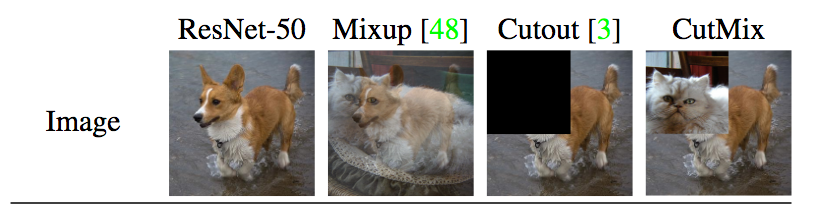

##### Data-augmentations

**Rand-Augment**: N transformations with a uniformly chosen parameters from K possible sets.
    
Transformations applied include: identity, autoContrast, equalize, rotation, solarization, etc.

For example, N=2
```
1) autoContrast(param_3/K) -> rotation(param_K-1/K)
2) solarization(param_10/K) -> identity
```

**MixUp**: Two interpolated samples and targets

```
loss = criterion(output, target_a) * lam + criterion(output, target_b) * (1. - lam)
```
https://github.com/clovaai/CutMix-PyTorch


**Repeated Augmentations**: samples (but differently augmented) are seen multiple times in the same batch

https://github.com/eladhoffer/convNet.pytorch

**Stochastic Depth**: randomly drop layer and keeps skip connection

```
y = x + drop_path(f(x))
  = x, p < drop_path_rate
  = x + f(x), otherwise
```

#### Takeaway

- Data-efficient training process
- Distillation

## Fun facts:

1) Paper published 24/12/2020 says:

> For reference, the current state of the art of 88.55% achieved with extra training data was obtained by the ViT-H model (600M parameters) trained on JFT-300M at resolution 512.

However, today (25/01/2021) SOTA on ImageNet with extra data is 90.2% by "[Meta Pseudo Labels](https://arxiv.org/abs/2003.10580v3)" and 88.61% by "[Sharpness-Aware Minimization for Efficiently Improving Generalization](https://arxiv.org/abs/2010.01412v2)"



## More references:

- [Visual Transformers: Token-based Image Representation and Processing for Computer Vision](https://arxiv.org/abs/2006.03677v3)